In [1]:
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from quera_ahs_utils.plotting import show_register
from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [2]:
nshots = 1000
t = 15.0

### Data Loading

[(1.4999999999999999e-05, 3.5e-05), (2.1539999999999997e-05, 3.5e-05), (2.8079999999999995e-05, 3.5e-05), (3.4620000000000004e-05, 3.5e-05), (4.115999999999999e-05, 3.5e-05), (4.77e-05, 3.5e-05)]


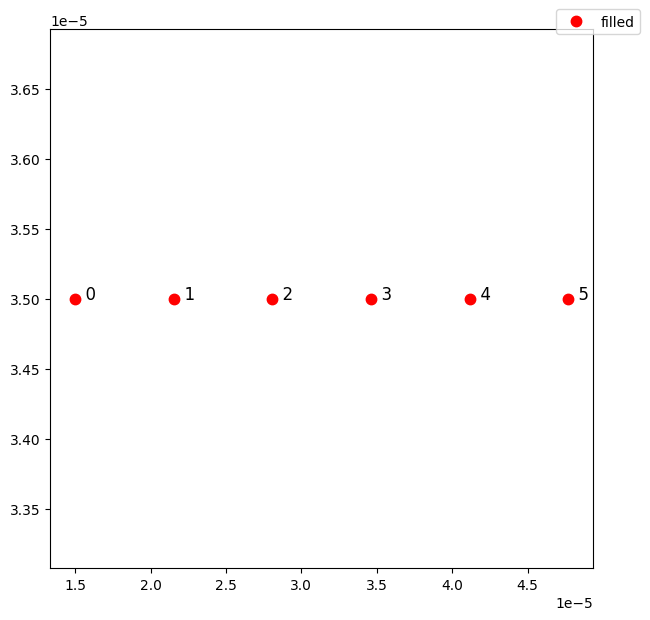

In [3]:
q_num = 6

# Define the atom positions
d = 6.54
pos = []
for i in range(q_num):
    pos.append((15+i*d, 35))
pos = [(x*1e-6, y*1e-6) for x, y in pos]
print(pos)

register = AtomArrangement()
for x, y in pos:
    register.add([x, y])

fig = show_register(register)
plt.show()

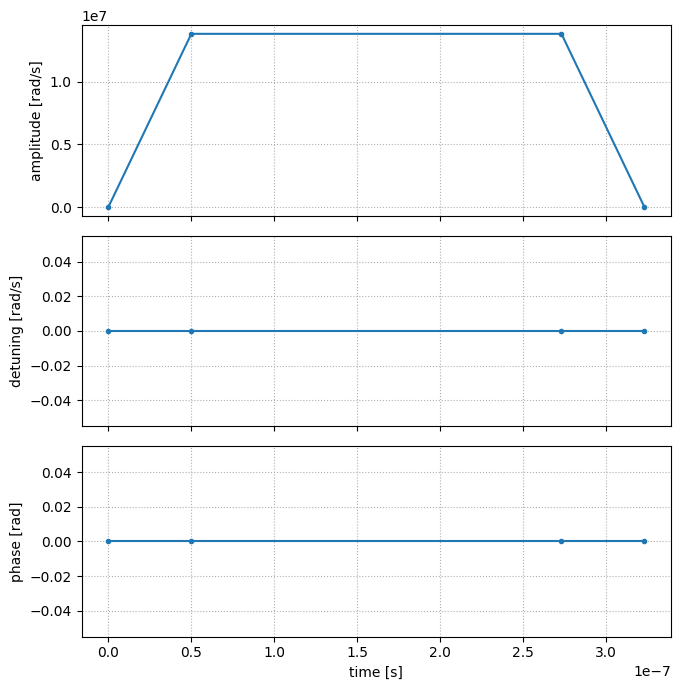

In [4]:
H = Hamiltonian()

omega_min = 0
omega_max = 2.2e6 * 2 * np.pi
detuning_min = 0
detuning_max = 0

t_evol = t*1.82e-8
t_ramp = 5e-8

time_points = [0, t_ramp, t_evol, t_evol + t_ramp]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_max, detuning_max, detuning_min]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.show()


In [5]:
ahs_program = AnalogHamiltonianSimulation(register=register, hamiltonian=H)

### Classiq Simulation

braket

In [6]:
from braket.devices import LocalSimulator

classical_device = LocalSimulator("braket_ahs")
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result().get_counts()
bitstring_counts = result

In [7]:
total_count = sum(bitstring_counts.values())
bitstring_probabilities = {key: value / total_count for key, value in bitstring_counts.items()}
quera_res = bitstring_probabilities
quera_res = {key.replace('g', '0').replace('r', '1'): value for key, value in quera_res.items()}

binary_length = q_num
all_binary_keys = [format(i, f'0{binary_length}b') for i in range(2**binary_length)]
for key in all_binary_keys:
    if key not in quera_res:
        quera_res[key] = 0
quera_res = {key: quera_res[key] for key in sorted(quera_res)}

qutip

In [8]:
# define the Hamiltonian and evolution time
x = sigmax()
z = sigmaz()
i = qeye(2)
n = (i-z)/2

N = q_num
tensor_ls = [qeye(2) for i in range(N)]
H = tensor(tensor_ls)
for j in range(N-1):
    pauli = [i for k in range(N)]
    pauli[j] = n
    pauli[j+1] = n
    H = H + 2 * np.pi * 4 * 0.05 * tensor(pauli)


for j in range(N):
    pauli = [i for k in range(N)]
    pauli[j] = x
    H = H + 2 * np.pi * 0.02 * tensor(pauli)

T = 1.0*t

In [9]:
# define the initial state
ls_tensor = [basis(2, 0) for i in range(N)]
psi0 = tensor(ls_tensor)

# Using qutip solver
result = sesolve(H, psi0, [0, T], [])
state_real = result.states[1].full()
num_qubits = int(np.log2(len(state_real)))
amplitudes = state_real.flatten()  
probabilities = {
    f"{i:0{num_qubits}b}": abs(amplitudes[i])**2 for i in range(len(amplitudes))
}

qutip_res = probabilities

/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Obseverble Convergence

In [10]:
def ob_value(bin_str1, bin_str2):
    
    if len(bin_str1) != len(bin_str2):
        raise ValueError("Binary strings must have the same length")

    # Compute bitwise product (AND operation)
    bitwise_product = [int(b1) & int(b2) for b1, b2 in zip(bin_str1, bin_str2)]

    # Compute modulo 2 sum (XOR sum of all resulting bits)
    mod2_sum = sum(bitwise_product) % 2

    return mod2_sum

def z_exp(res, size):
    Z_ob = [format(1 << i, f'0{size}b') for i in range(size)]

    ave_z = []
    for ob in Z_ob:
        exp_ob = 0
        for key, value in res.items():
            if ob_value(key, ob) == 0:
                # ground state
                exp_ob = exp_ob - 1 * value
            else:
                # excited state
                exp_ob = exp_ob + 1 * value
        ave_z.append(exp_ob)
    exp_z = sum(ave_z)/len(ave_z)

    return exp_z

def zz_exp(res, size):
    ZZ_ob = []
    for i in range(size-1):
        first_bit = 1 << i
        second_bit = 1 << ((i + 1) % size)  # Wrap around for the last element
        ZZ_ob.append(format(first_bit | second_bit, f'0{size}b'))

    ave_zz = []
    for ob in ZZ_ob:
        exp_ob = 0
        for key, value in res.items():
            if ob_value(key, ob) == 0:
                # 00 or 11
                exp_ob = exp_ob + 1 * value
            else:
                # 01 or 10
                exp_ob = exp_ob - 1 * value
        ave_zz.append(exp_ob)
    exp_zz = sum(ave_zz)/len(ave_zz)

    return exp_zz

In [11]:
print("Qutip Z:", z_exp(qutip_res, q_num))
print("QuEra Z:", z_exp(quera_res, q_num))

Qutip Z: -0.5029511438592147
QuEra Z: -0.5053333333333333


In [12]:
print("Qutip ZZ:", zz_exp(qutip_res, q_num))
print("QuEra ZZ:", zz_exp(quera_res, q_num))

Qutip ZZ: 0.1495898790966106
QuEra ZZ: 0.14839999999999998


### Simulation on Aquila

In [13]:
# from braket.aws import AwsDevice, AwsSession
# from boto3 import Session

# boto_session = Session(region_name="us-east-1")
# aws_session = AwsSession(boto_session)

# aquila = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila",aws_session)

# # To make the program compatible with the quantum hardware, we still need to slice it into discrete time steps:
# discretized_ahs_program = ahs_program.discretize(aquila)

In [14]:
# task = aquila.run(discretized_ahs_program, shots=nshots)